### Data reading for the monthly meeting


In [1]:
%matplotlib widget
from utils import concatenate_pv3_heatdata, read_pv3_heatdata_txt, get_settling_time, moving_average
import os, numpy as np, matplotlib.pyplot as plt
from scipy.signal import savgol_filter, butter, filtfilt, medfilt

In [2]:
file_path_lower_stack = "data/experimental/24_03_18/11_54_00/heatData/" # heating from 20°c
file_path_upper_stack = "data/experimental/24_03_15/" # heating from 20°c
file_path_lower_stack_fsf_low = "data/experimental/24_03_18/09_22_42/heatData/" # heating from 50°c
file_path_lower_stack_fsf_high = "data/experimental/24_03_18/09_56_52/heatData/" # heating from 50°c
file_path_lower_stack_ref = "data/experimental/24_03_18/10_29_59/heatData/" # heating from 50°c
file_path_upper_stack_evp30 = "data/experimental/24_03_20/17_31_44/heatData/" # heating from 28°c
file_path_upper_stack_evp30b = "data/experimental/24_03_21/09_06_16/heatData/" # heating from 20°c
file_path_lower_stack_evp30 = "data/experimental/24_03_21/09_06_19/heatData/" # heating from 20°c

# file_path = "data/experimental/24_03_12/11_48_31/heatData/"
bottom_stack_file = "Bottom Heat Controller worker.txt"
upper_stack_file = "Top Heat Controller worker.txt"
bottom_FSF_file = "Full state feedback control - Bottom Heat Controller worker.txt"
upper_FSF_file = "Full state feedback control - Top Heat Controller worker.txt"
cart_names = ["CT_" + str(i//4+1) + str((i%4) + 1) for i in range(16)]

In [3]:
# regroup data from the upper stack experiment if it wasn't done yet
if  not os.path.isfile("data/experimental/24_03_15/upper_stack.csv"):
    concatenate_pv3_heatdata(file_path_upper_stack, "data/experimental/24_03_15/upper_stack.csv", heatdata_filename=upper_stack_file)
file_path_upper_stack = "data/experimental/24_03_15/upper_stack.csv"

In [4]:
# data_temp_bot, headers_temp = read_pv3_heatdata_txt(file_path_lower_stack + bottom_stack_file)
data_temp_top, _ = read_pv3_heatdata_txt(file_path_upper_stack)
data_temp_bot, _ = read_pv3_heatdata_txt(file_path_lower_stack + bottom_stack_file)
data_temp_bot_fsf_low, _ = read_pv3_heatdata_txt(file_path_lower_stack_fsf_low + bottom_stack_file)
data_temp_bot_fsf_low_cmd, _ = read_pv3_heatdata_txt(file_path_lower_stack_fsf_low + bottom_FSF_file)
data_temp_bot_fsf_high, _ = read_pv3_heatdata_txt(file_path_lower_stack_fsf_high + bottom_stack_file)
data_temp_bot_fsf_high_cmd, _ = read_pv3_heatdata_txt(file_path_lower_stack_fsf_high + bottom_FSF_file)
data_temp_bot_ref, _ = read_pv3_heatdata_txt(file_path_lower_stack_ref + bottom_stack_file)
data_temp_top_evp30, _ = read_pv3_heatdata_txt(file_path_upper_stack_evp30 + upper_stack_file)
data_temp_bot_evp30, _ = read_pv3_heatdata_txt(file_path_lower_stack_evp30 + bottom_stack_file)
data_temp_top_evp30b, _ = read_pv3_heatdata_txt(file_path_upper_stack_evp30b + upper_stack_file)

In [5]:
# top temperature heating (20°c -> 175°c)
t_top_temp = (data_temp_top['Time'] - data_temp_top['Time'][0]) / 1e3 # conversion to seconds 
desired_out_top_temp_raw = np.array(data_temp_top['Target'])
out_top_temp_raw = np.array(data_temp_top['Stack'])
ct_top_temp_raw = []
for cart_name in cart_names:
    ct_top_temp_raw.append(data_temp_top[cart_name])
ct_top_temp_raw = np.array(ct_top_temp_raw)

# bot temperature heating (20°c -> 175°c)
t_bot_temp = (data_temp_bot['Time'] - data_temp_bot['Time'][0]) / 1e3 # conversion to seconds 
desired_out_bot_temp_raw = np.array(data_temp_bot['Target'])
out_bot_temp_raw = np.array(data_temp_bot['Stack'])
ct_bot_temp_raw = []
for cart_name in cart_names:
    ct_bot_temp_raw.append(data_temp_bot[cart_name])
ct_bot_temp_raw = np.array(ct_bot_temp_raw)

# bot temperature heating with low FSF (50°c -> 175°c)
t_fsfL_temp = (data_temp_bot_fsf_low['Time'] - data_temp_bot_fsf_low['Time'][0]) / 1e3 # conversion to seconds 
desired_out_fsfL_temp_raw = np.array(data_temp_bot_fsf_low['Target'])
out_fsfL_temp_raw = np.array(data_temp_bot_fsf_low['Stack'])
ct_fsfL_temp_raw = []
for cart_name in cart_names:
    ct_fsfL_temp_raw.append(data_temp_bot_fsf_low[cart_name])
ct_fsfL_temp_raw = np.array(ct_fsfL_temp_raw)
ct_fsfL_cmd_raw = []
for cart_name in cart_names:
    ct_fsfL_cmd_raw.append(data_temp_bot_fsf_low[cart_name+"_cmd"])
ct_fsfL_cmd_raw = np.array(ct_fsfL_cmd_raw)
t_fsfL_cmd = (data_temp_bot_fsf_low_cmd['Time'] - data_temp_bot_fsf_low['Time'][0]) / 1e3 # conversion to seconds 
fsfL_cmd_raw = np.array(data_temp_bot_fsf_low_cmd['FSF'])

# bot temperature heating with high FSF (50°c -> 175°c)
t_fsfH_temp = (data_temp_bot_fsf_high['Time'] - data_temp_bot_fsf_high['Time'][0]) / 1e3 # conversion to seconds 
desired_out_fsfH_temp_raw = np.array(data_temp_bot_fsf_high['Target'])
out_fsfH_temp_raw = np.array(data_temp_bot_fsf_high['Stack'])
ct_fsfH_temp_raw = []
for cart_name in cart_names:
    ct_fsfH_temp_raw.append(data_temp_bot_fsf_high[cart_name])
ct_fsfH_temp_raw = np.array(ct_fsfH_temp_raw)
ct_fsfH_cmd_raw = []
for cart_name in cart_names:
    ct_fsfH_cmd_raw.append(data_temp_bot_fsf_high[cart_name+"_cmd"])
ct_fsfH_cmd_raw = np.array(ct_fsfH_cmd_raw)
t_fsfH_cmd = (data_temp_bot_fsf_high_cmd['Time'] - data_temp_bot_fsf_high['Time'][0]) / 1e3 # conversion to seconds 
fsfH_cmd_raw = np.array(data_temp_bot_fsf_high_cmd['FSF'])

# bot temperature heating with previous ctrl as reference (50°c -> 175°c)
t_ref_temp = (data_temp_bot_ref['Time'] - data_temp_bot_ref['Time'][0]) / 1e3 # conversion to seconds 
desired_out_ref_temp_raw = np.array(data_temp_bot_ref['Target'])
out_ref_temp_raw = np.array(data_temp_bot_ref['Stack'])
ct_ref_temp_raw = []
for cart_name in cart_names:
    ct_ref_temp_raw.append(data_temp_bot_ref[cart_name])
ct_ref_temp_raw = np.array(ct_ref_temp_raw)

# top temperature heating with reference ctrl on EVP 3.0 (28°c -> 155°c)
t_evp30_temp = (data_temp_top_evp30['Time'] - data_temp_top_evp30['Time'][0]) / 1e3 # conversion to seconds 
desired_out_evp30_temp_raw = np.array(data_temp_top_evp30['Target'])
out_evp30_temp_raw = np.array(data_temp_top_evp30['Stack'])
ct_evp30_temp_raw = []
for cart_name in cart_names:
    ct_evp30_temp_raw.append(data_temp_top_evp30[cart_name])
ct_evp30_temp_raw = np.array(ct_evp30_temp_raw)

# top temperature heating with reference ctrl on EVP 3.0 (20°c -> 155°c)
t_top_evp30_temp = (data_temp_top_evp30['Time'] - data_temp_top_evp30['Time'][0]) / 1e3 # conversion to seconds 
desired_out_top_evp30_temp_raw = np.array(data_temp_top_evp30['Target'])
out_top_evp30_temp_raw = np.array(data_temp_top_evp30['Stack'])
ct_top_evp30_temp_raw = []
for cart_name in cart_names:
    ct_top_evp30_temp_raw.append(data_temp_top_evp30[cart_name])
ct_top_evp30_temp_raw = np.array(ct_top_evp30_temp_raw)

# bottom temperature heating with reference ctrl on EVP 3.0 (20°c -> 155°c)
t_bot_evp30_temp = (data_temp_bot_evp30['Time'] - data_temp_bot_evp30['Time'][0]) / 1e3 # conversion to seconds 
desired_out_bot_evp30_temp_raw = np.array(data_temp_bot_evp30['Target'])
out_bot_evp30_temp_raw = np.array(data_temp_bot_evp30['Stack'])
ct_bot_evp30_temp_raw = []
for cart_name in cart_names:
    ct_bot_evp30_temp_raw.append(data_temp_bot_evp30[cart_name])
ct_bot_evp30_temp_raw = np.array(ct_bot_evp30_temp_raw)

## Comparison between the lower and upper stack heating transmission

### EVP 3.1

In [6]:
# make sure the data from the concatenated file is well sorted
t_top_temp_n = t_top_temp[np.argsort(t_top_temp)]
desired_out_top_temp_raw = desired_out_top_temp_raw[np.argsort(t_top_temp)]
out_top_temp_raw = out_top_temp_raw[np.argsort(t_top_temp)]
ct_top_temp_raw = ct_top_temp_raw[:,np.argsort(t_top_temp)]
t_top_temp = t_top_temp_n - t_top_temp_n[0]

In [7]:
# setting the data on the same time frame
min_t = np.min([t_top_temp[-1], t_bot_temp[-1]])
# crop the data according to the max time
desired_out_top_temp_raw = desired_out_top_temp_raw[t_top_temp <= min_t]
out_top_temp_raw = out_top_temp_raw[t_top_temp <= min_t]
ct_top_temp_raw = ct_top_temp_raw[:,t_top_temp <= min_t]
t_top_temp = t_top_temp[t_top_temp <= min_t]

desired_out_bot_temp_raw = desired_out_bot_temp_raw[t_bot_temp <= min_t]
out_bot_temp_raw = out_bot_temp_raw[t_bot_temp <= min_t]
ct_bot_temp_raw = ct_bot_temp_raw[:,t_bot_temp <= min_t]
t_bot_temp = t_bot_temp[t_bot_temp <= min_t]

In [8]:
# crop the data so that every target start at the same timing
t_dtop = t_ref_temp[np.where(np.abs(np.diff(t_top_temp)) > 0)[0][0]]
t_dbot = t_fsfL_temp[np.where(np.abs(np.diff(t_bot_temp)) > 0)[0][0]]
min_td = np.min([t_dtop, t_dbot])
# cropping the data 
# top
out_top_temp_raw = out_top_temp_raw[t_top_temp >= (t_dtop - min_td)]
ct_top_temp_raw = ct_top_temp_raw[:, t_top_temp >= t_dtop - min_td]
desired_out_top_temp_raw = desired_out_top_temp_raw[t_top_temp >= t_dtop - min_td]
t_top_temp = t_top_temp[t_top_temp >= t_dtop - min_td] - (t_dtop - min_td)
# bot
out_bot_temp_raw = out_bot_temp_raw[t_bot_temp >= (t_dbot - min_td)]
ct_bot_temp_raw = ct_bot_temp_raw[:, t_bot_temp >= t_dbot - min_td]
desired_out_bot_temp_raw = desired_out_bot_temp_raw[t_bot_temp >= t_dbot - min_td]
t_bot_temp = t_bot_temp[t_bot_temp >= t_dbot - min_td] - (t_dbot - min_td)

In [9]:
# 5% settling response time
t5p_top_temp = get_settling_time(t_top_temp, out_top_temp_raw, settling_percent=0.05, target=175)
t5p_bot_temp = get_settling_time(t_bot_temp, out_bot_temp_raw, settling_percent=0.05, target=175)
t5p_top_EVP31 = t5p_top_temp - min_td
t5p_bot_EVP31 = t5p_bot_temp - min_td
print("The Upper stack settling time is {:d} min {:.2f}s.".format(int(t5p_top_EVP31//60), t5p_top_EVP31%60))
print("The Lower stack settling time is {:d} min {:.2f}s. (+{:2f}%)".format(int(t5p_bot_EVP31//60), t5p_bot_EVP31%60, 100*(t5p_bot_EVP31-t5p_top_EVP31)/t5p_top_EVP31))

The Upper stack settling time is 12 min 35.16s.
The Lower stack settling time is 13 min 41.87s. (+8.832772%)


In [10]:
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

fig, ax = plt.subplots(2,1,sharex=True)
ax[1].set_xlabel('Time (s)') 
ax[0].set_ylabel('Temperature (°c)')
ax[0].set_title('Top stack')
ax[1].set_ylabel('Temperature (°c)')
ax[1].set_title('Bottom stack')
ax[0].plot(t_top_temp, out_top_temp_raw, linewidth=2, label="stack")
for i, ct_temp in enumerate(ct_top_temp_raw):
    ax[0].plot(t_top_temp, ct_temp, color=color_list[np.mod(i,8)], label=cart_names[i], linewidth=0.75)
ax[0].plot(t_top_temp, desired_out_top_temp_raw, color="black", linestyle="dashed", label="target", linewidth=1)
ax[0].axvline(x=t5p_top_temp, color=color_list[4], linestyle="dashed", linewidth=1)
ax[1].plot(t_bot_temp, out_bot_temp_raw, linewidth=2)
for i, ct_temp in enumerate(ct_bot_temp_raw):
    ax[1].plot(t_bot_temp, ct_temp, color=color_list[np.mod(i,8)], linewidth=0.75)
ax[1].plot(t_bot_temp, desired_out_bot_temp_raw, color="black", linestyle="dashed", linewidth=1)
ax[1].axvline(x=t5p_bot_temp, color=color_list[4], linestyle="dashed", linewidth=1)
fig.suptitle('EVP 3.1: Heating comparison between the upper and lower stack')
fig.tight_layout()
fig.subplots_adjust(right=0.84)
fig.legend(loc='upper center', bbox_to_anchor=(0.925, 0.89), fancybox=True, borderaxespad=0)
# 

### EVP 3.0

In [11]:
# setting the data on the same time frame
min_t = np.min([t_top_evp30_temp[-1], t_bot_evp30_temp[-1]])
# crop the data according to the max time
desired_out_t_top_evp30_temp_temp_raw = desired_out_top_evp30_temp_raw[t_top_evp30_temp <= min_t]
out_top_evp30_temp_raw = out_top_evp30_temp_raw[t_top_evp30_temp <= min_t]
ct_top_evp30_temp_raw = ct_top_evp30_temp_raw[:,t_top_evp30_temp <= min_t]
t_top_evp30_temp = t_top_evp30_temp[t_top_evp30_temp <= min_t]

desired_out_bot_evp30_temp_raw = desired_out_bot_evp30_temp_raw[t_bot_evp30_temp <= min_t]
out_bot_evp30_temp_raw = out_bot_evp30_temp_raw[t_bot_evp30_temp <= min_t]
ct_bot_evp30_temp_raw = ct_bot_evp30_temp_raw[:,t_bot_evp30_temp <= min_t]
t_bot_evp30_temp = t_bot_evp30_temp[t_bot_evp30_temp <= min_t]

In [12]:
# crop the data so that every target start at the same timing
t_dtop_evp30 = t_top_evp30_temp[np.where(np.abs(np.diff(t_top_evp30_temp)) > 0)[0][0]]
t_dbot_evp30 = t_bot_evp30_temp[np.where(np.abs(np.diff(t_bot_evp30_temp)) > 0)[0][0]]
min_td = np.min([t_dtop, t_dbot])
# cropping the data 
# top
out_top_evp30_temp_raw = out_top_evp30_temp_raw[t_top_evp30_temp >= (t_dtop_evp30 - min_td)]
ct_top_evp30_temp_raw = ct_top_evp30_temp_raw[:, t_top_evp30_temp >= t_dtop_evp30 - min_td]
desired_out_top_evp30_temp_raw = desired_out_top_evp30_temp_raw[t_top_evp30_temp >= t_dtop_evp30 - min_td]
t_top_evp30_temp = t_top_evp30_temp[t_top_evp30_temp >= t_dtop_evp30 - min_td] - (t_dtop_evp30 - min_td)
# bot
out_bot_evp30_temp_raw = out_bot_evp30_temp_raw[t_bot_evp30_temp >= (t_dbot_evp30 - min_td)]
ct_bot_evp30_temp_raw = ct_bot_evp30_temp_raw[:, t_bot_evp30_temp >= t_dbot_evp30 - min_td]
desired_out_bot_evp30_temp_raw = desired_out_bot_evp30_temp_raw[t_bot_evp30_temp >= t_dbot_evp30 - min_td]
t_bot_evp30_temp = t_bot_evp30_temp[t_bot_evp30_temp >= t_dbot_evp30 - min_td] - (t_dbot_evp30 - min_td)

In [13]:
# filtering the evp 3.0 data to get rid off pt100 sensor artifacts
cutoff = 0.03
fs = 1/np.mean(np.diff(t_top_evp30_temp))
out_top_evp30_temp_filt = medfilt(out_top_evp30_temp_raw, kernel_size=5)
b, a = butter(N=10, Wn=cutoff/(0.5*fs), btype='lowpass', analog=False)
out_top_evp30_temp_filt = filtfilt(b, a, out_top_evp30_temp_filt)

fs = 1/np.mean(np.diff(t_bot_evp30_temp))
out_bot_evp30_temp_filt = medfilt(out_bot_evp30_temp_raw, kernel_size=7) # kernel needs to be bigger here
b, a = butter(N=10, Wn=cutoff/(0.5*fs), btype='lowpass', analog=False)
out_bot_evp30_temp_filt = filtfilt(b, a, out_bot_evp30_temp_filt)

In [14]:
# 5% settling response time
t5p_top_evp30_temp = get_settling_time(t_top_evp30_temp, out_top_evp30_temp_filt, settling_percent=0.05, target=155)
t5p_bot_evp30_temp = get_settling_time(t_bot_evp30_temp, out_bot_evp30_temp_filt, settling_percent=0.05, target=155)
t5p_top_EVP30 = t5p_top_evp30_temp - min_td
t5p_bot_EVP30 = t5p_bot_evp30_temp - min_td
print("The Upper stack settling time is {:d} min {:.2f} s. (+{:.2f}%)".format(int(t5p_top_EVP30//60), t5p_top_EVP30%60, 100*(t5p_top_EVP30-t5p_top_EVP31)/t5p_top_EVP31))
print("The Lower stack settling time is {:d} min {:.2f} s. (+{:.2f}%)".format(int(t5p_bot_EVP30//60), t5p_bot_EVP30%60, 100*(t5p_bot_EVP30-t5p_top_EVP31)/t5p_top_EVP31))

The Upper stack settling time is 21 min 23.60 s. (+69.98%)
The Lower stack settling time is 25 min 31.75 s. (+102.84%)


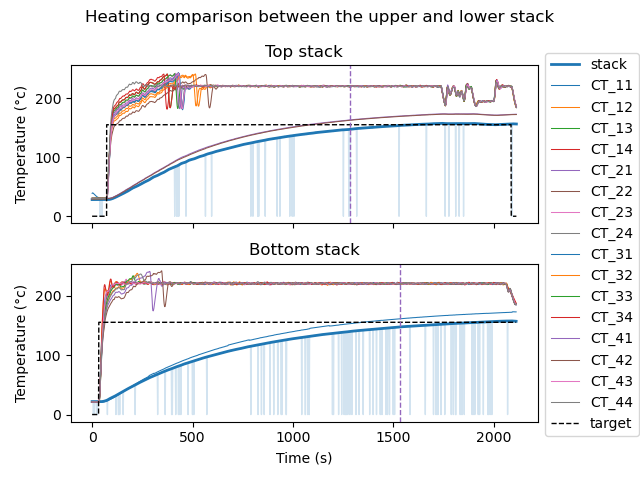

In [15]:
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

fig, ax = plt.subplots(2,1,sharex=True)
ax[1].set_xlabel('Time (s)') 
ax[0].set_ylabel('Temperature (°c)')
ax[0].set_title('Top stack')
ax[1].set_ylabel('Temperature (°c)')
ax[1].set_title('Bottom stack')
ax[0].plot(t_top_evp30_temp, out_top_evp30_temp_raw, color=color_list[0], alpha=0.2, linewidth=1)
ax[0].plot(t_top_evp30_temp, out_top_evp30_temp_filt, color=color_list[0], linewidth=2, label="stack")
for i, ct_temp in enumerate(ct_top_evp30_temp_raw):
    ax[0].plot(t_top_evp30_temp, ct_temp, color=color_list[np.mod(i,8)], label=cart_names[i], linewidth=0.75)
ax[0].plot(t_top_evp30_temp, desired_out_top_evp30_temp_raw, color="black", linestyle="dashed", label="target", linewidth=1)
ax[0].axvline(x=t5p_top_evp30_temp, color=color_list[4], linestyle="dashed", linewidth=1)

ax[1].plot(t_bot_evp30_temp, out_bot_evp30_temp_raw, color=color_list[0], alpha=0.2, linewidth=1)
ax[1].plot(t_bot_evp30_temp, out_bot_evp30_temp_filt, color=color_list[0], linewidth=2)
for i, ct_temp in enumerate(ct_bot_evp30_temp_raw):
    ax[1].plot(t_bot_evp30_temp, ct_temp, color=color_list[np.mod(i,8)], linewidth=0.75)
ax[1].plot(t_bot_evp30_temp, desired_out_bot_evp30_temp_raw, color="black", linestyle="dashed", linewidth=1)
ax[1].axvline(x=t5p_bot_evp30_temp, color=color_list[4], linestyle="dashed", linewidth=1)
fig.suptitle('EVP 3.0: Heating comparison between the upper and lower stack')
fig.tight_layout()
fig.subplots_adjust(right=0.84)
fig.legend(loc='upper center', bbox_to_anchor=(0.925, 0.89), fancybox=True, borderaxespad=0)

## Comparison with the different control strategies

In [16]:
# An error in the low gains full state feedback control lead to a delayed start of the heating
desired_out_fsfL_temp_raw[0:291] = desired_out_fsfH_temp_raw[0]
fsfL_cmd_raw = fsfL_cmd_raw + np.mean(out_fsfL_temp_raw[191:291])
fsfH_cmd_raw = fsfH_cmd_raw + np.mean(out_fsfH_temp_raw[0:30])
# t_fsfL_cmd = t_fsfL_cmd + 31.2

In [17]:
# crop the data so that every target start at the same timing
t_dref = t_ref_temp[np.where(np.abs(np.diff(desired_out_ref_temp_raw)) > 0)[0][0]]
t_dfsfL = t_fsfL_temp[np.where(np.abs(np.diff(desired_out_fsfL_temp_raw)) > 0)[0][0]]
t_dfsfH = t_fsfH_temp[np.where(np.abs(np.diff(desired_out_fsfH_temp_raw)) > 0)[0][0]]
min_td = np.min([t_dref, t_dfsfL, t_dfsfH])
# cropping the data 
# ref
out_ref_temp_raw = out_ref_temp_raw[t_ref_temp >= (t_dref - min_td)]
ct_ref_temp_raw = ct_ref_temp_raw[:, t_ref_temp >= t_dref - min_td]
desired_out_ref_temp_raw = desired_out_ref_temp_raw[t_ref_temp >= t_dref - min_td]
t_ref_temp = t_ref_temp[t_ref_temp >= t_dref - min_td] - (t_dref - min_td)
# FSFL
out_fsfL_temp_raw = out_fsfL_temp_raw[t_fsfL_temp >= (t_dfsfL - min_td)]
ct_fsfL_temp_raw = ct_fsfL_temp_raw[:, t_fsfL_temp >= t_dfsfL - min_td]
ct_fsfL_cmd_raw = ct_fsfL_cmd_raw[:, t_fsfL_temp >= t_dfsfL - min_td]
desired_out_fsfL_temp_raw = desired_out_fsfL_temp_raw[t_fsfL_temp >= t_dfsfL - min_td]
fsfL_cmd_raw = fsfL_cmd_raw[t_fsfL_cmd >= t_dfsfL - min_td]
t_fsfL_temp = t_fsfL_temp[t_fsfL_temp >= t_dfsfL - min_td] - (t_dfsfL - min_td)
t_fsfL_cmd = t_fsfL_cmd[t_fsfL_cmd >= t_dfsfL - min_td] - (t_dfsfL - min_td)
# FSFH
out_fsfH_temp_raw = out_fsfH_temp_raw[t_fsfH_temp >= (t_dfsfH - min_td)]
ct_fsfH_temp_raw = ct_fsfH_temp_raw[:, t_fsfH_temp >= t_dfsfH - min_td]
ct_fsfH_cmd_raw = ct_fsfH_cmd_raw[:, t_fsfH_temp >= t_dfsfH - min_td]
desired_out_fsfH_temp_raw = desired_out_fsfH_temp_raw[t_fsfH_temp >= t_dfsfH - min_td]
fsfH_cmd_raw = fsfH_cmd_raw[t_fsfH_cmd >= t_dfsfH - min_td]
t_fsfH_temp = t_fsfH_temp[t_fsfH_temp >= t_dfsfH - min_td] - (t_dfsfH - min_td)
t_fsfH_cmd = t_fsfH_cmd[t_fsfH_cmd >= t_dfsfH - min_td] - (t_dfsfH - min_td)


In [18]:
# compute the moving average of the cartridges command (time on)
ct_fsfL_cmd_mavg = np.array([moving_average(ct_cmd, n=20) for ct_cmd in ct_fsfL_cmd_raw])
ct_fsfH_cmd_mavg = np.array([moving_average(ct_cmd, n=20) for ct_cmd in ct_fsfH_cmd_raw])

In [19]:
# 5% settling response time
t5p_ref_temp = get_settling_time(t_ref_temp, out_ref_temp_raw, settling_percent=0.05, target=175)
idx_t5p_ref_temp = np.where(t_ref_temp >= t5p_ref_temp)[0][0]
t5p_fsfL_temp = get_settling_time(t_fsfL_temp, out_fsfL_temp_raw, settling_percent=0.05, target=175)
idx_t5p_fsfL_temp = np.where(t_fsfL_temp >= t5p_fsfL_temp)[0][0]
t5p_fsfH_temp = get_settling_time(t_fsfH_temp, out_fsfH_temp_raw, settling_percent=0.05, target=175)
idx_t5p_fsfH_temp = np.where(t_fsfH_temp >= t5p_fsfH_temp)[0][0]
print("The reference control settling time is {:d} min {:.2f} s.".format(int((t5p_ref_temp - min_td)//60), (t5p_ref_temp - min_td)%60))
print("The full state feedback control with low gains settling time is {:d} min {:.2f} s.\nIt represents a reduction of {:.1f}% relatively to the initial control.".format(int((t5p_fsfL_temp - min_td)//60), (t5p_fsfL_temp - min_td)%60, 100*(1-(t5p_fsfL_temp - min_td)/(t5p_ref_temp - min_td))))
print("The full state feedback control with high gains settling time is {:d} min {:.2f} s.\nIt represents a reduction of {:.1f}% relatively to the initial control.".format(int((t5p_fsfH_temp - min_td)//60), (t5p_fsfH_temp - min_td)%60, 100*(1-(t5p_fsfH_temp - min_td)/(t5p_ref_temp - min_td))))

The reference control settling time is 10 min 31.13 s.
The full state feedback control with low gains settling time is 8 min 15.25 s.
It represents a reduction of 21.5% relatively to the initial control.
The full state feedback control with high gains settling time is 7 min 8.90 s.
It represents a reduction of 32.0% relatively to the initial control.


In [20]:
# computation of the mean and std temperature of the steady states of each control startegy
# reference
out_ref_temp_mean = np.mean(out_ref_temp_raw[t_ref_temp>(t5p_ref_temp+100)])
out_ref_temp_std = np.std(out_ref_temp_raw[t_ref_temp>(t5p_ref_temp+100)])
# low gains
out_fsfL_temp_mean = np.mean(out_fsfL_temp_raw[(t_fsfL_temp>(t5p_fsfL_temp+100)) & (t_fsfL_temp<1400)])
out_fsfL_temp_std = np.std(out_fsfL_temp_raw[(t_fsfL_temp>(t5p_fsfL_temp+100)) & (t_fsfL_temp<1400)])
# high gains
out_fsfH_temp_mean = np.mean(out_fsfH_temp_raw[t_fsfH_temp>(t5p_fsfH_temp+100)])
out_fsfH_temp_std = np.std(out_fsfH_temp_raw[t_fsfH_temp>(t5p_fsfH_temp+100)])
print("Reference mean error: {:.2f} (STD {:.2f})°c.".format(175-out_ref_temp_mean, out_ref_temp_std))
print("Full State Feedback low gains mean error: {:.2f} (STD {:.2f})°c.".format(175-out_fsfL_temp_mean, out_fsfL_temp_std))
print("Full State Feedback high gains mean error: {:.2f} (STD {:.2f})°c.".format(175-out_fsfH_temp_mean, out_fsfH_temp_std))

Reference mean error: -0.72 (STD 1.11)°c.
Full State Feedback low gains mean error: -0.05 (STD 0.82)°c.
Full State Feedback high gains mean error: 0.01 (STD 0.10)°c.


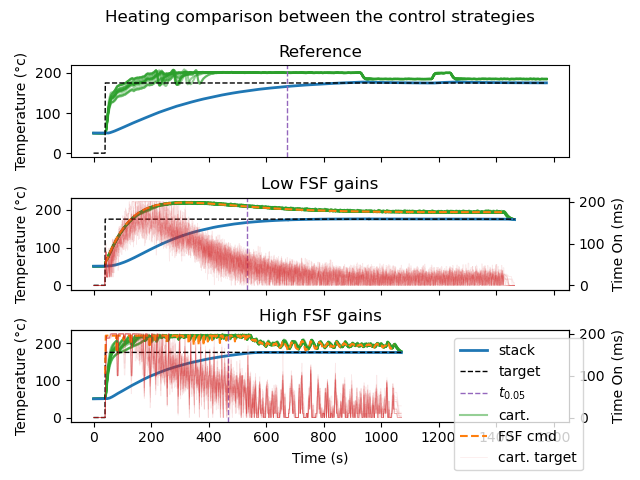

In [21]:
fig, ax = plt.subplots(3,1,sharex=True)
ax[-1].set_xlabel('Time (s)') 
ax[0].set_ylabel('Temperature (°c)')
ax[0].set_title('Reference')
ax[1].set_ylabel('Temperature (°c)')
ax[1].set_title('Low FSF gains')
ax[2].set_ylabel('Temperature (°c)')
ax[2].set_title('High FSF gains')

for i, ct_temp in enumerate(ct_ref_temp_raw):
    ax[0].plot(t_ref_temp, ct_temp, color=color_list[2], alpha=0.5) # , label=cart_names[i]
ax[0].plot(t_ref_temp, out_ref_temp_raw, linewidth=2, label="stack")
ax[0].plot(t_ref_temp, desired_out_ref_temp_raw, color="black", linestyle="dashed", label="target", linewidth=1)
ax[0].axvline(x = t5p_ref_temp, color=color_list[4], label = r'$t_{0.05}$', linestyle="dashed", linewidth=1)

axB = ax[1].twinx()
axB.set_ylabel('Time On (ms)')
for i, (ct_temp, ct_cmd) in enumerate(zip(ct_fsfL_temp_raw, ct_fsfL_cmd_mavg)):
    if i == 0:
        ax[1].plot(t_fsfL_temp, ct_temp, color=color_list[2], alpha=0.5, label="cart.")
        axB.plot(t_fsfL_temp, ct_cmd, color=color_list[3], alpha=0.1, label="cart. target", linewidth=0.5)
    else:
        ax[1].plot(t_fsfL_temp, ct_temp, color=color_list[2], alpha=0.5)
        axB.plot(t_fsfL_temp, ct_cmd, color=color_list[3], alpha=0.1, linewidth=0.5)

ax[1].plot(t_fsfL_temp, out_fsfL_temp_raw, linewidth=2)
ax[1].plot(t_fsfL_temp, desired_out_fsfL_temp_raw, color="black", linestyle="dashed", linewidth=1)
ax[1].plot(t_fsfL_cmd, fsfL_cmd_raw, color=color_list[1], linestyle="dashed", linewidth=1.5, label="FSF cmd")
ax[1].axvline(x = t5p_fsfL_temp, color=color_list[4], linestyle="dashed", linewidth=1)

axB = ax[2].twinx()
axB.set_ylabel('Time On (ms)')
for i, (ct_temp, ct_cmd) in enumerate(zip(ct_fsfH_temp_raw, ct_fsfH_cmd_mavg)):
    ax[2].plot(t_fsfH_temp, ct_temp, color=color_list[2], alpha=0.5)
    axB.plot(t_fsfH_temp, ct_cmd, color=color_list[3], alpha=0.1, linewidth=0.5)
ax[2].plot(t_fsfH_temp, out_fsfH_temp_raw, linewidth=2)
ax[2].plot(t_fsfH_temp, desired_out_fsfH_temp_raw, color="black", linestyle="dashed", linewidth=1)
ax[2].plot(t_fsfH_cmd, fsfH_cmd_raw, color=color_list[1], linestyle="dashed", linewidth=1.5)
ax[2].axvline(x = t5p_fsfH_temp, color=color_list[4], linestyle="dashed", linewidth=1)

# fig.legend(loc='upper center', bbox_to_anchor=(1, 0.9), fancybox=True)
fig.legend(loc='upper center', bbox_to_anchor=(0.81, 0.31), fancybox=True)
fig.suptitle('Heating comparison between the control strategies')
fig.tight_layout()

In [22]:
fig.tight_layout()

In [23]:
fig.legend(loc='upper center', bbox_to_anchor=(0.81, 0.31), fancybox=True)

## Comparison between the EVP 3.0 and EVP 3.1

In [24]:
# TODO: this only works if the targert is set later than on min_td
t_devp30 = t_evp30_temp[np.where(np.abs(np.diff(desired_out_evp30_temp_raw)) > 0)[0][0]]
# cropping the data 
out_evp30_temp_raw = out_evp30_temp_raw[t_evp30_temp >= (t_devp30 - min_td)]
ct_evp30_temp_raw = ct_evp30_temp_raw[:, t_evp30_temp >= t_devp30 - min_td]
desired_out_evp30_temp_raw = desired_out_evp30_temp_raw[t_evp30_temp >= t_devp30 - min_td]
t_evp30_temp = t_evp30_temp[t_evp30_temp >= t_devp30 - min_td] - (t_devp30 - min_td)

In [25]:
# filtering the evp 3.0 data to get rid off sensor artifacts
fs = 1/np.mean(np.diff(t_evp30_temp))
cutoff = 0.03
# out_evp30_temp_filt = savgol_filter(out_evp30_temp_raw, window_length=50, polyorder=2)
out_evp30_temp_filt = medfilt(out_evp30_temp_raw, kernel_size=5) # best results for the filtering
b, a = butter(N=10, Wn=cutoff/(0.5*fs), btype='lowpass', analog=False)
out_evp30_temp_filt = filtfilt(b, a, out_evp30_temp_filt)

In [26]:
# 5% settling response time
t5p_evp30_temp = get_settling_time(t_evp30_temp, out_evp30_temp_filt, settling_percent=0.05, target=155)
idx_t5p_evp30_temp = np.where(t_evp30_temp >= t5p_evp30_temp)[0][0]

In [27]:
out_evp30_temp_mean = np.mean(out_evp30_temp_raw[t_evp30_temp>(t5p_evp30_temp+100)])
out_evp30_temp_std = np.std(out_evp30_temp_raw[t_evp30_temp>(t5p_evp30_temp+100)])

In [28]:
fig, ax = plt.subplots(1,1,sharex=True)
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Temperature (°c)')

ax.plot(t_ref_temp, out_ref_temp_raw, linewidth=2, label="EVP 3.1")
ax.plot(t_fsfH_temp, out_fsfH_temp_raw, linewidth=2, label="EVP 3.1 opt.")
ax.plot(t_evp30_temp, out_evp30_temp_raw, linewidth=2, color=color_list[2],alpha=0.2)
ax.plot(t_evp30_temp, out_evp30_temp_filt, linewidth=2, color=color_list[2], label="EVP 3.0")
ax.plot(t_ref_temp, desired_out_ref_temp_raw, color="black", linestyle="dashed", label="target EVP 3.1", linewidth=1)
ax.plot(t_evp30_temp, desired_out_evp30_temp_raw, color="gray", linestyle="dashed", label="target ECP 3.0", linewidth=1)
ax.axvline(x = t5p_fsfH_temp, color=color_list[4], linestyle="dashed", linewidth=1)
ax.axvline(x = t5p_ref_temp, color=color_list[4], linestyle="dashed", linewidth=1)
ax.axvline(x = t5p_evp30_temp, color=color_list[4], linestyle="dashed", linewidth=1)
ax.plot(t_ref_temp[idx_t5p_ref_temp], out_ref_temp_raw[idx_t5p_ref_temp], '*', color=color_list[3])
ax.plot(t_fsfH_temp[idx_t5p_fsfH_temp], out_fsfH_temp_raw[idx_t5p_fsfH_temp], '*', color=color_list[3])
ax.plot(t_evp30_temp[idx_t5p_evp30_temp], out_evp30_temp_raw[idx_t5p_evp30_temp], '*', color=color_list[3])

fig.legend(loc='upper center', bbox_to_anchor=(0.85, 0.7), fancybox=True)
fig.suptitle('Heating duration improvement (EVP 3.1)')
fig.tight_layout()

In [60]:
print("The reference control on the EVP 3.0 settling time is {:d} min {:.2f} s.".format(int((t5p_evp30_temp - min_td)//60), (t5p_evp30_temp - min_td)%60))
print("The reference control on the EVP 3.1 settling time is {:d} min {:.2f} s.\nIt represents a reduction of {:.1f}% relatively to the initial control on EVP 3.0.".format(int((t5p_ref_temp - min_td)//60), (t5p_ref_temp - min_td)%60, 100*(1-(t5p_ref_temp - min_td)/(t5p_evp30_temp - min_td))))
print("The full state feedback control with high gains settling time is {:d} min {:.2f} s.\nIt represents a reduction of {:.1f}% relatively to the initial control on EVP 3.0.".format(int((t5p_fsfH_temp - min_td)//60), (t5p_fsfH_temp - min_td)%60, 100*(1-(t5p_fsfH_temp - min_td)/(t5p_evp30_temp - min_td))))

The reference control on the EVP 3.0 settling time is 20 min 11.50 s.
The reference control on the EVP 3.1 settling time is 10 min 31.13 s.
It represents a reduction of 47.9% relatively to the initial control on EVP 3.0.
The full state feedback control with high gains settling time is 7 min 8.90 s.
It represents a reduction of 64.6% relatively to the initial control on EVP 3.0.
